In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

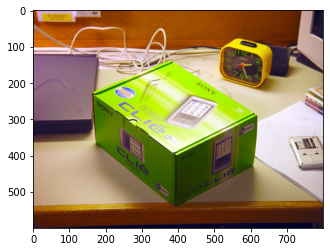

In [2]:
# Load image
im = np.array(Image.open('sony.jpg'))
plt.imshow(im)

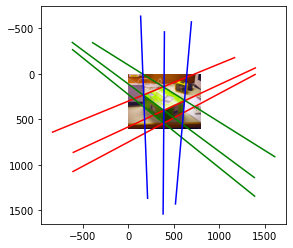

In [3]:
# Obtain some parallel lines to the axes manually

# Obtained from sony.jpg
x_para = [
    [(393, 539), (607, 425)], # Two points -> One line (X, Y) order
    [(396, 398), (618, 295)],
    [(168, 230), (383, 142)],
]

y_para = [
    [(385, 396), (168, 235)],
    [(388, 538), (173, 365)],
    [(609, 283), (387, 144)],
]

z_para = [
    [(390, 538), (390, 400)],
    [(606, 428), (617, 291)],
    [(174, 366), (168, 235)],
]

# Visualize the lines XYZ-RGB
plt.imshow(im)
extend = 1000
for l in x_para:
    slope = (l[1][1] - l[0][1]) / (l[1][0] - l[0][0] + 1e-6)
    plt.plot((l[0][0]-extend, l[0][0]+extend), (l[0][1]-extend*slope, l[0][1]+extend*slope), 'r-')
for l in y_para:
    slope = (l[1][1] - l[0][1]) / (l[1][0] - l[0][0] + 1e-6)
    plt.plot((l[0][0]-extend, l[0][0]+extend), (l[0][1]-extend*slope, l[0][1]+extend*slope), 'g-')
for l in z_para:
    slope = (l[1][1] - l[0][1]) / (l[1][0] - l[0][0] + 1)
    ex = min(extend, np.abs(1000/slope)) # handle nasty division by zero
    plt.plot((l[0][0]-ex, l[0][0]+ex), (l[0][1]-ex*slope, l[0][1]+ex*slope), 'b-')

plt.show()

Use your brain power to convince yourself where the vanishing points should be.

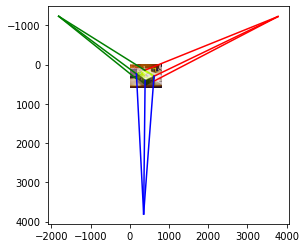

In [4]:
# Compute the vanishing points using Bob Collin's method
def get_vanishing_points(lines):
    moment = np.zeros((3, 3))
    for l in lines:
        e1 = np.array([*l[0], 1]).astype(np.float32)
        e2 = np.array([*l[1], 1]).astype(np.float32)
        inf_line = np.cross(e1, e2)[:, None]
        moment += inf_line @ inf_line.T
    # Find best fit
    w, v = np.linalg.eig(moment)
    i = np.argmin(w)
    return v[:, i] / v[2, i]
        
vx = get_vanishing_points(x_para)
vy = get_vanishing_points(y_para)
vz = get_vanishing_points(z_para)

# Visualize the lines with the vanishing point XYZ-RGB
plt.imshow(im)
for l in x_para:
    plt.plot((vx[0], l[1][0]), (vx[1], l[1][1]), 'r-')
for l in y_para:
    plt.plot((vy[0], l[1][0]), (vy[1], l[1][1]), 'g-')
for l in z_para:
    plt.plot((vz[0], l[1][0]), (vz[1], l[1][1]), 'b-')

plt.show()

These vanishing points should match your intuition.

In [5]:
# Compute the vanishing lines
lxy = np.cross(vx, vy)
lxz = np.cross(vx, vz)
lyz = np.cross(vy, vz)

In [6]:
# Define the image of the origin, i.e. the bottom center of the box
origin = np.array([393, 539, 1])

## Projection matrix
# Define reference scale. These scales can come from real measurement or human fantasy
x_ref_length = 200
y_ref_length = 400
z_ref_length = 100
# The corresponding image positions of the reference points.
ref_x = [607, 425, 1]
ref_y = [173, 365, 1]
ref_z = [396, 398, 1]

# Compute the scales in the projection mtrix from reference scale
ax = ((ref_x-origin)[0:2] / (vx-ref_x)[0:2] / x_ref_length).mean()
ay = ((ref_y-origin)[0:2] / (vy-ref_y)[0:2] / y_ref_length).mean()
az = ((ref_z-origin)[1:2] / (vz-ref_z)[1:2] / z_ref_length).mean() # Not so stable in x -- hard to label

# Obtain the projection matrix, see slides
proj = np.stack([vx*ax, vy*ay, vz*az, origin], 1)
print(proj)

[[ 1.28944392e+00 -4.97714271e-01 -1.46041627e-01  3.93000000e+02]
 [-4.18545877e-01 -3.38706644e-01 -1.57469325e+00  5.39000000e+02]
 [ 3.41380713e-04  2.74425779e-04 -4.13802124e-04  1.00000000e+00]]


In [7]:
# Helper functions to obtain 3D coordinates, following notations in Desmond & Stanley's writeup
def get_coord(o, I, b, t, v, a):
    b = np.array([*b, 1])
    t = np.array([*t, 1])
    
    return -(o.dot(I)*np.linalg.norm(np.cross(b, t))) / (b.dot(I)*np.linalg.norm(np.cross(v, t))) / a

# Used for the co-z method. Measure the height from the ground plane
# b - Image position of a point on the ground plane. 
#     This point should have the same 3D (x,y) as the point that you are going to measure
# t - Image position of the point that you are going to measure
def get_z_co_z(b, t):
    return get_coord(origin, lxy, b, t, vz, az)

# Used the co-plane method. Measure x/y given a height.
# proj - the projection matrix
# z - the height of the current reference plane
def get_h_co_plane(proj, z):
    h = np.concatenate([proj[:, 0:2], proj[:, 3:4]+(az*vz*z)[:,None]], 1)
    return np.linalg.inv(h)

In [8]:
## Now assume that we didn't know the 3D coordinates of the Sony box and we want to compute that

# Forward homography on the reference plane, followed by filling the plane height
def get_3d(h, x, z):
    w = (h @ [*x, 1])
    w[0:2] = w[0:2] / w[2]
    w[2] = z
    return w

# First we use the co-plane method to obtain 3D coordinates on the ground plane from image coordinates
h = get_h_co_plane(proj, 0)
box_bottom_center = get_3d(h, (393,539), 0)
box_bottom_left = get_3d(h, (173,365), 0)
box_bottom_right = get_3d(h, (607,425), 0)
print('Coordinates of points on the bottom plane')
print(box_bottom_center, box_bottom_left, box_bottom_right)

# Second we use the co-z method to obtain the height of the top side
z_pi = get_z_co_z((393,539), (390,394))
print('Height of box:', z_pi)

# With that height, obtain a new reference plane, and obtain the points' 3D coordinates from image coordinates
h = get_h_co_plane(proj, z_pi)
box_top_center = get_3d(h, (390,394), z_pi)
box_top_left = get_3d(h, (162,226), z_pi)
box_top_right = get_3d(h, (617,291), z_pi)
print('Coordinates of points on the top plane')
print(box_top_center, box_top_left, box_top_right)

Coordinates of points on the bottom plane
[2.84217094e-14 0.00000000e+00 0.00000000e+00] [ -2.01985516 398.97068513   0.        ] [199.69161938   3.17847115   0.        ]
Height of box: 99.47720111584324
Coordinates of points on the top plane
[ 0.87269385  9.1530202  99.47720112] [  0.5187324  412.74952382  99.47720112] [198.41238979   1.37919578  99.47720112]


That isn't very interesting since we already kinda know a lot of the box
Let's obtain some 3D information about that alarm clock that is sitting on the same ground plane as the box.
The principal is the same -- use co-plane and co-z.

In [9]:
# For the alarm clock
h = get_h_co_plane(proj, 0)
clock_bottom_center = get_3d(h, (627,217), 0)
clock_bottom_left = get_3d(h, (515,188), 0)
clock_bottom_right = get_3d(h, (652,189), 0)
print('Coordinates of points on the bottom side')
print(clock_bottom_center, clock_bottom_left, clock_bottom_right)

# Now we compute the coordinates for the top side
z_pi = get_z_co_z((627,217), (635,124))
print('Height of alarm clock:', z_pi)

# Get the homography for the top plane
h = get_h_co_plane(proj, z_pi)
clock_top_center = get_3d(h, (635,124), z_pi)
clock_top_left = get_3d(h, (534,95), z_pi)
clock_top_right = get_3d(h, (658,106), z_pi)
print('Coordinates of points on the top side')
print(clock_top_center, clock_top_left, clock_top_right)

Coordinates of points on the bottom side
[407.34200516 304.65988736   0.        ] [365.91172788 446.74783762   0.        ] [454.55199938 333.92212702   0.        ]
Height of alarm clock: 74.77674166483197
Coordinates of points on the top side
[407.70049948 303.66486178  74.77674166] [376.54043685 436.91899264  74.77674166] [442.87960354 318.4861834   74.77674166]


Now we can compute 3D coordaintes all we want. Next up we can perform homography to obtain textures. Textures can then be mapped onto the 3D model for better visualization.

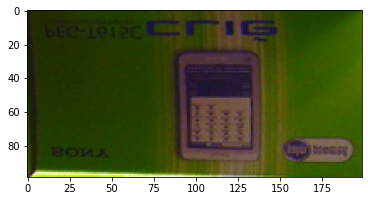

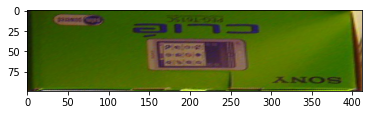

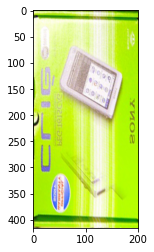

In [10]:
## Texture mapping using homographies
# Should be easy. Demo here for reference.
import cv2

def padded_warp_and_crop(im, src_pts, dst_pts):
    h, _ = cv2.findHomography(np.array(src_pts), np.array(dst_pts))
    
    max_x = max_y = 0
    min_x = im.shape[1]
    min_y = im.shape[0]
    for c in src_pts:
        p = h @ np.array([*c, 1])
        p = p/p[2]
        min_x = min(min_x, p[0])
        min_y = min(min_y, p[1])
        max_x = max(max_x, p[0])
        max_y = max(max_y, p[1])
    translation = np.array([[1,0,min_x],[0,1,min_y],[0,0,1]])
    ht = translation @ h
    warpped = cv2.warpPerspective(im, ht, (int(max_x-min_x), int(max_y-min_y)))
    return warpped

text_x = padded_warp_and_crop(im, [(393,539),(390,394),(607,425),(617,291)], 
                              [box_bottom_center[[0,2]], 
                              box_top_center[[0,2]],
                              box_bottom_right[[0,2]],
                              box_top_right[[0,2]]])
plt.imshow(text_x)
plt.show()

text_y = padded_warp_and_crop(im, [(393,539),(390,394),(173,365),(162,226)], 
                              [box_bottom_center[[1,2]], 
                              box_top_center[[1,2]],
                              box_bottom_left[[1,2]],
                              box_top_left[[1,2]]])
plt.imshow(text_y)
plt.show()

# We need one more point to do homography. Compute the coordinate for the far point on the top side.
top_far_im = (377, 137)
z_pi = get_z_co_z((393,539), (390,394))
h = get_h_co_plane(proj, z_pi)
box_top_far = get_3d(h, top_far_im, z_pi)
text_z = padded_warp_and_crop(im, [(390,394),(162,226),(617,291),top_far_im], 
                              [box_top_center[[0,1]], 
                              box_top_left[[0,1]],
                              box_top_right[[0,1]],
                              box_top_far[[0,1]]])
plt.imshow(text_z)
plt.show()

With the 3D positions of the corners and the texture maps, we can reconstruct the texture-mapped 3D shape easily.